# PubMed Papers: Exploratory Data Analysis

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [129]:
#read in cleaned file
filename = '../data/pubmed_cleaned.csv'

In [130]:
df = pd.read_csv(filename)

In [131]:
df.head() 

,pmid,title,text,date,citations
0,32416782,Artificial intelligence and the future of glob...,Concurrent advances in information technology ...,2020-05-01,10
1,32414188,Future Is Unlicensed: Private 5G Unlicensed Ne...,This paper aims to unlock the unlicensed band ...,2020-05-01,0
2,32413821,A review of modern technologies for tackling C...,Objective: Science and tech...,2020-08-01,23
3,32411818,Report on computational assessment of Tumor In...,Assessment of tumor-infiltrating lymphocytes (...,2020-05-01,3
4,32410553,Application of Artificial Intelligence in Phar...,Background: Artificial inte...,2020-06-01,0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2986 entries, 0 to 2985
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pmid       2986 non-null   int64 
 1   title      2986 non-null   object
 2   text       2986 non-null   object
 3   date       2986 non-null   object
 4   citations  2986 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 116.8+ KB


In [133]:
df.isnull().sum()

pmid         0
title        0
text         0
date         0
citations    0
dtype: int64

In [134]:
df.duplicated().sum()

0

#### Explore Proposed Target Variable: 'citations'

In [135]:
max(df['citations'])

704

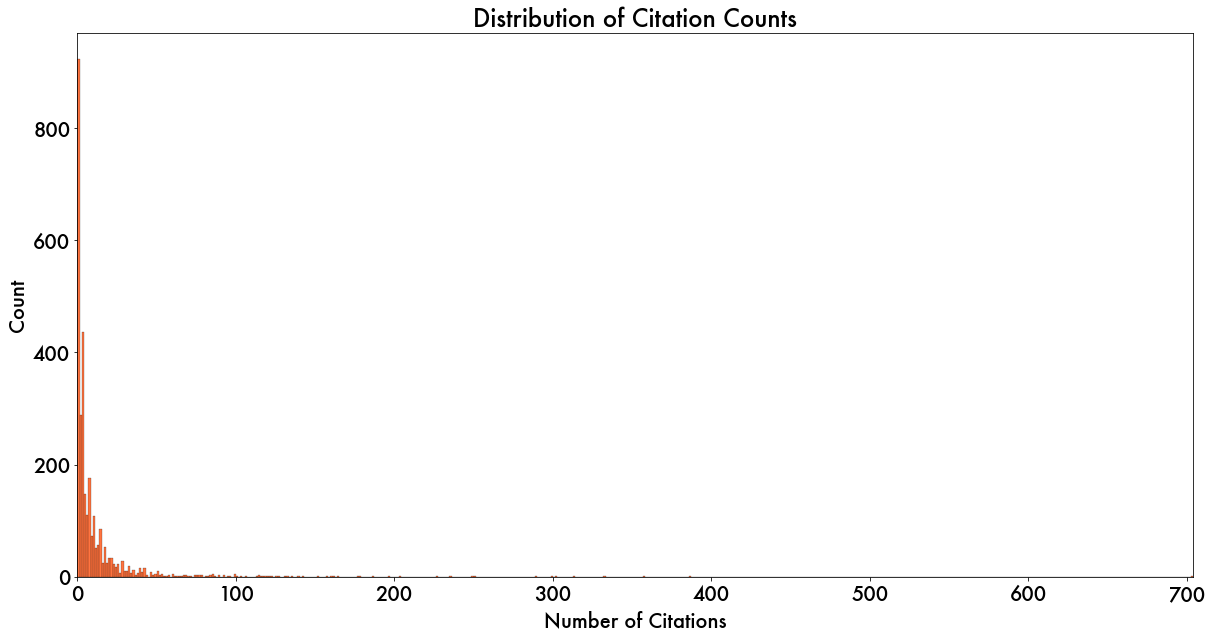

In [136]:
#Look at the distribution of the citation counts
plt.figure(figsize = (20, 10));
sns.histplot(data=df, x='citations', color='orangered');
figurefont = {'fontname' : 'Futura'};
plt.title('Distribution of Citation Counts', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Number of Citations',**figurefont, fontsize = 20);
plt.ylabel('Count',**figurefont, fontsize = 20);
plt.xlim(0,max(df['citations']))
plt.savefig('../figures/pubmed_citations_histplot.jpg',  bbox_inches = "tight")

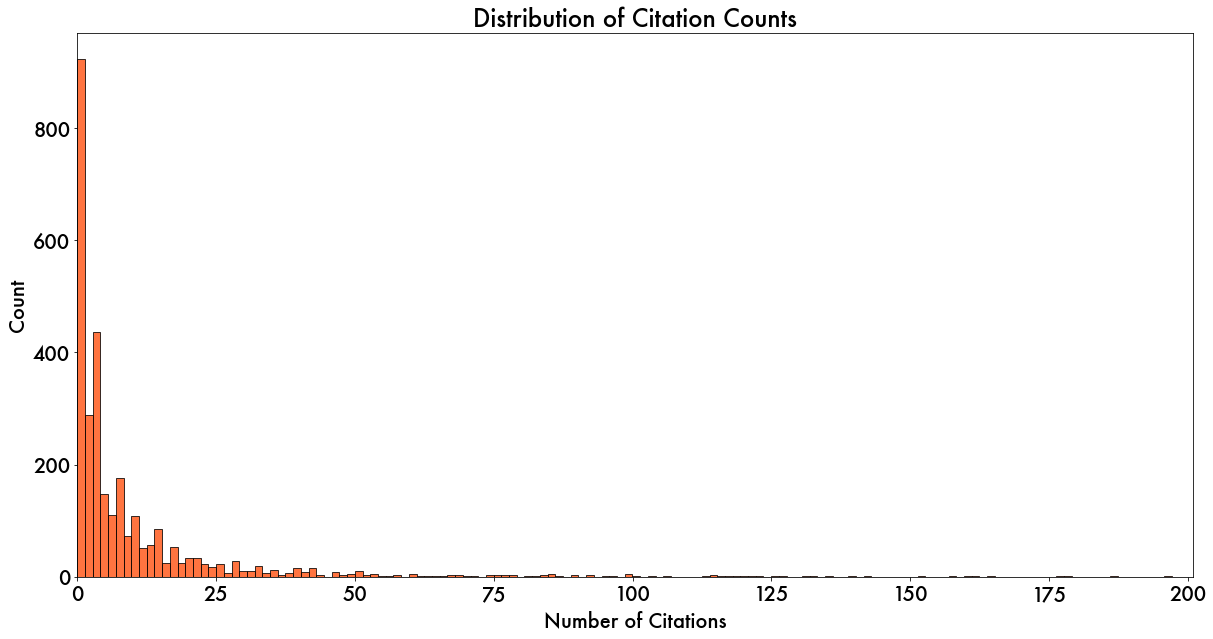

In [137]:
#Zoom in on 0-200 at the distribution of the citation counts
plt.figure(figsize = (20, 10));
figurefont = {'fontname' : 'Futura'};
plt.title('Distribution of Citation Counts', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Number of Citations',**figurefont, fontsize = 20);
plt.ylabel('Count',**figurefont, fontsize = 20);
plt.xlim(0,201)
sns.histplot(data=df, x='citations', color='orangered');
plt.savefig('../figures/pubmed_citations_histplot_zoom.jpg',  bbox_inches = "tight")

In [138]:
#the target variable is highly right-skewed
df['citations'].skew()

9.098907965034183

### Explore Log of Citations

In [139]:
#Explore log of citations
df_log = df.copy()
df_log['log_citations'] = np.log(df_log['citations'])


#removing null or infinite values
df_log = df_log[np.isfinite(df_log['log_citations'])]


In [140]:
df_log.shape

(2447, 6)

Lost a lot of data here....

In [141]:
(df_log['citations'] == 0).sum()

0

Ah - that's right - can't calculate the log of 0; so we're losing all of the abstracts with no citations. Not going to work for this purpose. Back to the df; I'll address my skew issues in other ways.

### Explore Relationships with Target Variable

In [142]:
df.describe()

,pmid,citations
count,2.986000e+03,2986.000000
mean,3.034788e+07,11.797053
std,2.748997e+06,29.680358
min,1.996910e+07,0.000000
25%,2.936660e+07,1.000000
50%,3.115368e+07,4.000000
75%,3.232295e+07,11.000000
max,3.394824e+07,704.000000


#### Is the length of the abstract correlated with the target variable?

In [143]:
#check out some preliminary correlations
df['len_text']=df['text'].apply(len)
df['citations'].corr(df['len_text'])

-0.0338319421494336

No correlation here. 

In [144]:
#check out some preliminary correlations
df['len_title']=df['title'].apply(len)
df['citations'].corr(df['len_title'])

-0.10401146061438526

Citations do not appear correlated with the length of the title.

### Is there an effect of time on # of citations?

In [145]:
# convert date column to datetime object
df['date'] = pd.to_datetime(df['date'])

In [146]:
#sort the df in reverse chronological order
df.sort_values('date', inplace=True)

In [147]:
# create a new column that shows how long the posts had been live as of when they were pulled

df['days_live'] = (pd.to_datetime('2021-05-08') - df['date']).dt.days

In [148]:
# look at the correlation 
df['citations'].corr(df['days_live'])

0.31848997870910084

There does appear to be a slight positive correlation between the length of time that the article has existed with the number of citations. This makes sense. 

### Remove Outliers

In [162]:
#check out outliers (abstracts that are three standard deviations above the mean)

In [150]:
num_columns = ['citations', 'len_text', 'len_title', 'days_live']

In [151]:
for col in num_columns: 
    print(f'{col} has {(df[col] > (df[col].mean()+(3*df[col].std()))).sum()} outliers.')

citations has 50 outliers.
len_text has 34 outliers.
len_title has 24 outliers.
days_live has 69 outliers.


In [152]:
df.shape

(2986, 8)

In [153]:
#drop outliers

for col in num_columns:
    df = df[(df[col] <= ((df[col].mean())+(3*(df[col].std()))))]

In [154]:
df.shape

(2809, 8)

In [155]:
df.describe()

,pmid,citations,len_text,len_title,days_live
count,2.809000e+03,2809.000000,2809.000000,2809.00000,2809.000000
mean,3.061512e+07,8.692417,1329.957992,83.40121,839.709505
std,2.352070e+06,14.176571,464.415876,28.45909,655.015418
min,2.207523e+07,0.000000,17.000000,12.00000,158.000000
25%,2.961473e+07,1.000000,1000.000000,63.00000,341.000000
50%,3.124898e+07,3.000000,1292.000000,81.00000,646.000000
75%,3.235154e+07,10.000000,1639.000000,101.00000,1072.000000
max,3.394824e+07,99.000000,2874.000000,173.00000,3233.000000


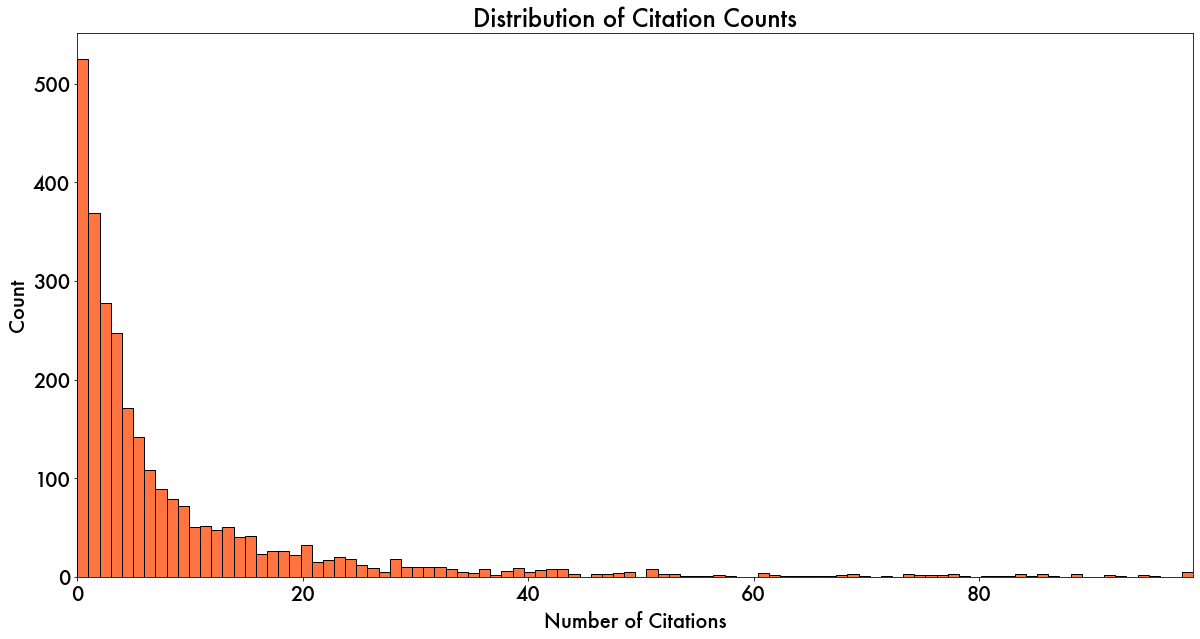

In [163]:
#Look at the distribution of the citation counts
plt.figure(figsize = (20, 10));
sns.histplot(data=df, x='citations', color='orangered', bins=100);
figurefont = {'fontname' : 'Futura'};
plt.title('Distribution of Citation Counts', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Number of Citations',**figurefont, fontsize = 20);
plt.ylabel('Count',**figurefont, fontsize = 20);
plt.xlim(0,max(df['citations']))
plt.savefig('../figures/pubmed_citations_histplot_no_outliers.jpg',  bbox_inches = "tight")

### Can we establish a "highly-cited" category?

In [157]:
#if I want to turn this into a clf problem and use all posts with citations greater than 1 std above the mean....
sum(df['citations'] > df['citations'].mean() + df['citations'].std())

286

It's only about 10% of the data....I might need to adjust my criterion a bit. 

In [158]:
#if I want to turn this into a clf problem and use all posts with citations greater than 1 std above the mean....
sum(df['citations'] > 10)

678

The 75% threshold is 10, so that seems reasonable. Top quartile of articles. 

In [159]:
df['citations'].skew()

3.260109719319966

The skew has improved without the outliers. 

In [160]:
df.to_csv('../data/pubmed_cleaned_no_outliers.csv')